# Predicting Customer Churn: Using Machine Learning in Business Analytics
## By Juston Suell - DSC630

### Import Necessary Libraries
Let's start by importing the libraries we'll need for data manipulation, visualization, and modeling.

In [29]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Setting up the visual aesthetics for plots
sns.set(style='whitegrid')


### Load and Inspect the Dataset
Here, we'll load the dataset and perform an initial inspection to understand its structure.

In [30]:
# Loading the dataset
df = pd.read_csv('/Users/jwsue/Desktop/DSC630 Predictive Analytics/Telco-Customer-Churn.csv')

# Displaying the first few rows of the dataset to understand its structure
print(df.head())

# Checking for missing values
print(df.isnull().sum())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

### Data Cleaning and Preprocessing
This step involves handling missing values, encoding categorical variables, and scaling numerical features.

In [31]:
# Filling missing values for numerical columns with the mean
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Handling categorical variables using OneHotEncoder
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                    'PaperlessBilling', 'PaymentMethod']

# Applying OneHotEncoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scaling numerical features
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the updated dataset structure
print(df.head())


C:\Users\jwsue\AppData\Local\Temp\ipykernel_25000\2245266863.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


   customerID  SeniorCitizen    tenure  MonthlyCharges  TotalCharges Churn  \
0  7590-VHVEG              0 -1.277445       -1.160323     -0.994971    No   
1  5575-GNVDE              0  0.066327       -0.259629     -0.173876    No   
2  3668-QPYBK              0 -1.236724       -0.362660     -0.960399   Yes   
3  7795-CFOCW              0  0.514251       -0.746535     -0.195400    No   
4  9237-HQITU              0 -1.236724        0.197365     -0.941193   Yes   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0        False         True           False             False  ...   
1         True        False           False              True  ...   
2         True        False           False              True  ...   
3         True        False           False             False  ...   
4        False        False           False              True  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   


Missing values in the TotalCharges column are handled by converting it to numeric, and filling with the mean. Categorical columns are encoded using get_dummies() to convert them into a format suitable for modeling. Numerical columns are scaled using StandardScaler to improve the performance of the machine learning model.

### Visualizations for Data Exploration
Now, let's create some visualizations to explore the data and understand the relationships between different features.

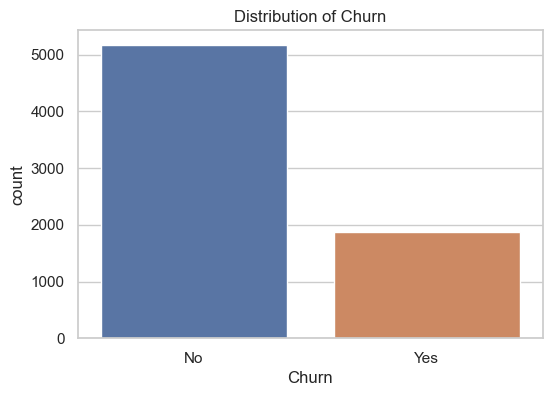

In [32]:
# Distribution of Churn
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()


This plot shows the distribution of churn vs. non-churn customers. It helps to visualize the class imbalance

C:\Users\jwsue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


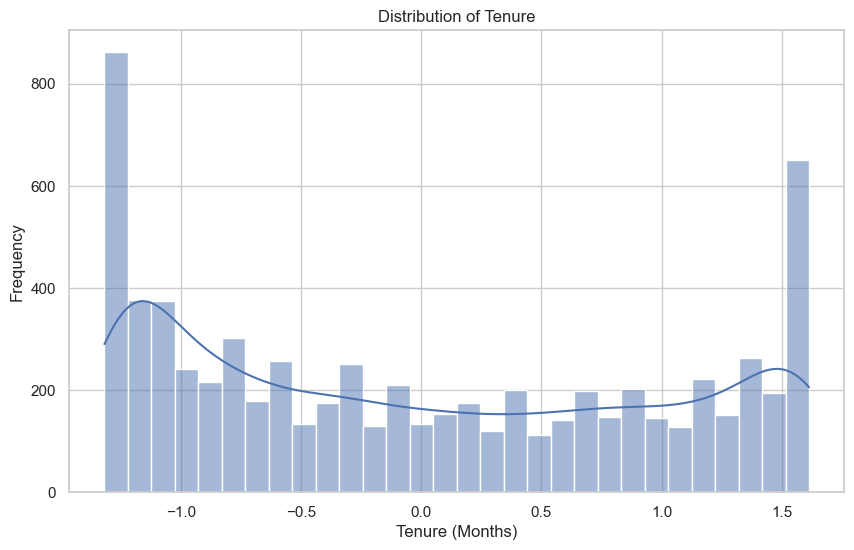

In [33]:
# Distribution of Tenure
plt.figure(figsize=(10, 6))
sns.histplot(df['tenure'], kde=True, bins=30)
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Frequency')
plt.show()


The histogram of tenure shows how long customers typically stay with the company before churning.

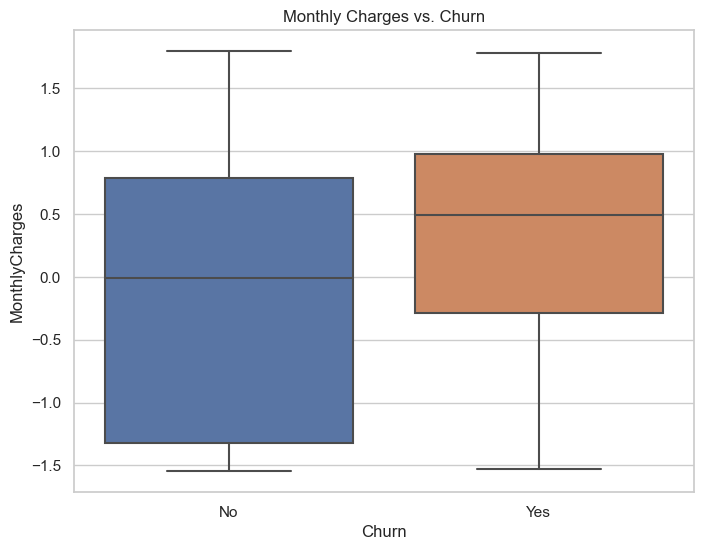

In [34]:
# Boxplot of Monthly Charges vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs. Churn')
plt.show()


This boxplot helps us to see how monthly charges differ between customers who churn and those who don’t.

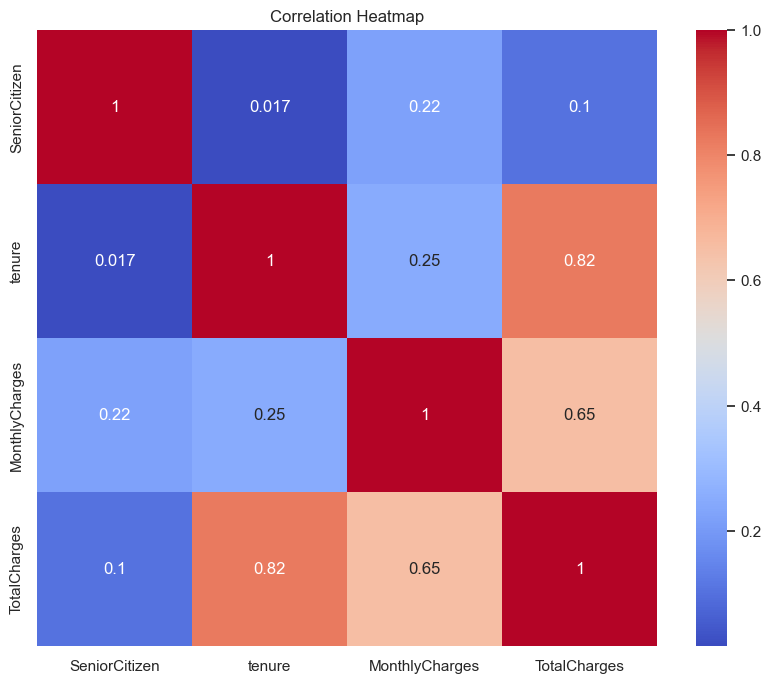

In [35]:
# Correlation heatmap
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


This heatmap shows the correlation between numerical features in the DataFrame, indicating how strongly they are related to each other

### Model Training and Evaluation
Here we will train a RandomForest model and evaluate its performance.

In [54]:
# Define the feature matrix (X) and the target vector (y)
X = df.drop('Churn_Yes', axis=1)  # Drop the target column from the features
y = df['Churn_Yes']  # Use the one-hot encoded column as the target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Displaying the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')


Accuracy: 0.79
Precision: 0.67
Recall: 0.47
F1 Score: 0.55
ROC-AUC: 0.69


The dataset is split into training and testing sets using a 70:30 ratio. The RandomForestClassifier is trained, and predictions are made on the test set. Several performance metrics are calculated and displayed.

### Feature Importance Visualization
Let's visualize the importance of the features in the RandomForest model

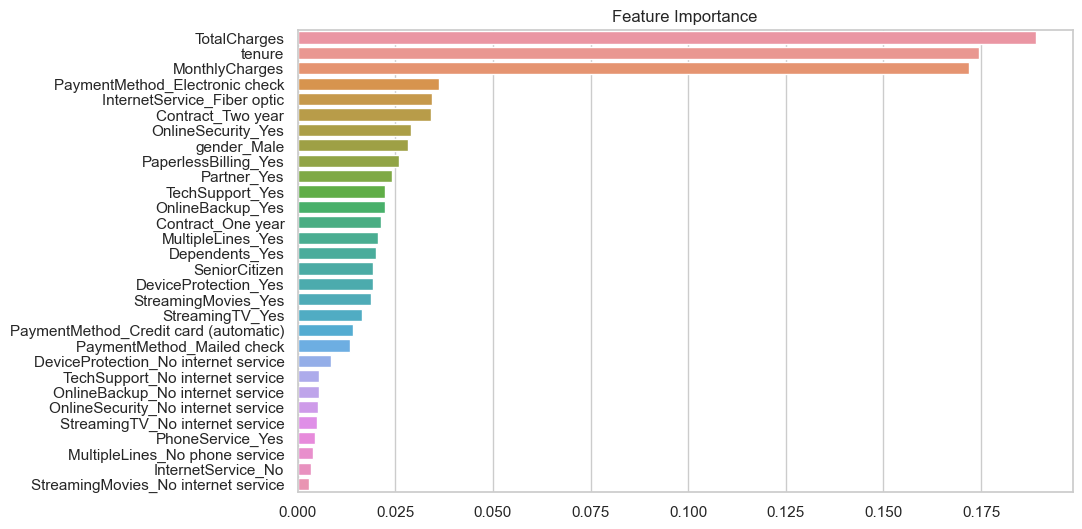

In [55]:
# Feature importance visualization
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()


This bar plot displays the importance of each feature in predicting customer churn.